# Generate Data set

This notebook generates a simulated dataset for the FCAL LED gain monitoring system. It duplicates similar code Mike wrote that also does this. The main differences:

1. The $\alpha$ values are generated from a sin^2(x) function rather than a sawtooth
2. The LED outputs are named "A0", "A1", ... instead of "b0", "b1".
3. The output includes the true $\alpha$ value and the $\omega$ value at each step.

In [1]:
import pandas as pd
import numpy as np

Nsteps = 3000
Nfeatures = 50


df = pd.DataFrame()
df["t"] = range(0, Nsteps)


In [2]:

# Similar to what Mike used for his alpha, but use sin^2 so that the derivative is continuous
def GenerateAlpha(Nsteps, mean=1.0, amp=0.1, period=200):
    df["alpha"] = 1.0 + amp * (np.sin(df["t"]*2.0*np.pi/period/2.0)**2 - 0.5)

# Generate a set of omegas by sampling from a gaussian distribution.
# The values are duplicated for each time step to make later calculations easier
def GenerateOmegas(Nsteps, Nfeatures, mean=1.0, sigma= 0.05):
    global df
    
    # Generate random samples for each feature
    random_samples = np.random.normal(mean, sigma, size=(1, Nfeatures))
    random_samples = np.repeat(random_samples, Nsteps, axis=0)

    # Create a DataFrame with columns w0, w1, w2, ...
    column_names = [f'w{i}' for i in range(Nfeatures)]

    tmp_df = pd.DataFrame(random_samples, columns=column_names) 
    df = pd.concat([df, tmp_df], axis=1)

# Generate a set of omegas by sampling from a gaussian distribution.
# The values are duplicated for each time step to make later calculations easier
def GenerateGains(Nsteps, Nfeatures, amp_mean=0.0, amp_sigma= 0.05, period_mean=600.0, period_sigma=50.0, phase_mean=0.0, phase_sigma=200.0):
    global df
    
    # Generate random samples for parameters A1_X, T1_X, phase1_x, A2_X, T2_X, phase2_X
    A1_X = np.random.normal(amp_mean, amp_sigma, size=Nfeatures)
    T1_X = np.random.normal(period_mean, period_sigma, size=Nfeatures)
    phase1_x = np.random.normal(phase_mean, phase_sigma, size=Nfeatures)
    A2_X = np.random.normal(amp_mean, amp_sigma, size=Nfeatures)
    T2_X = np.random.normal(period_mean/3.0, period_sigma, size=Nfeatures)
    phase2_X = np.random.normal(phase_mean, phase_sigma, size=Nfeatures)
    
    # Generate columns g0, g1, g2, ... using the provided formula
    for i in range(Nfeatures):
        t = np.arange(Nsteps)  # Replace this with your actual time values
        g_X = 1.0 + A1_X[i] * np.cos(t * 2 * np.pi / T1_X[i] + phase1_x[i]) + A2_X[i] * np.cos(t * 2 * np.pi / T2_X[i] + phase2_X[i])
        df[f'g{i}'] = g_X

# Calculate the A values from alpha, omega, and g values
def CalculateAmps(Nfeatures):
    global df
    for i in range(Nfeatures):
        df[f'A{i}'] = df['alpha']*df[f'w{i}']*df[f'g{i}']

# Generate all values
GenerateAlpha(Nsteps)
GenerateOmegas(Nsteps, Nfeatures)
GenerateGains(Nsteps, Nfeatures)
CalculateAmps(Nfeatures)
print(df.columns)


Index(['t', 'alpha', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7',
       ...
       'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49'],
      dtype='object', length=152)


/tmp/ipykernel_980/3198964694.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'A{i}'] = df['alpha']*df[f'w{i}']*df[f'g{i}']
/tmp/ipykernel_980/3198964694.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'A{i}'] = df['alpha']*df[f'w{i}']*df[f'g{i}']
/tmp/ipykernel_980/3198964694.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

<Axes: >

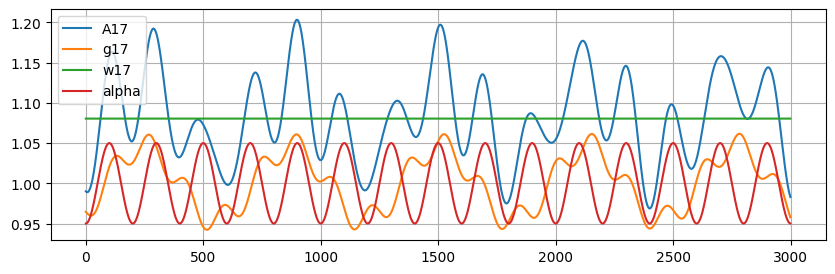

In [3]:

df.plot(y=["A17", "g17", "w17", "alpha"], kind="line", grid=True, figsize=(10,3))

In [4]:
filename = 'fcal_DLv2.csv'
df.to_csv(filename)
